# USA Car Sales EDA

##### Created by Lucas Zarpellon

LinkedIn https://www.linkedin.com/in/lucasingleszarpellon/
<br>
E-mail lucasiz.zarpellon0@gmail.com
<br>
GitHub
https://github.com/lcszarpellon

#### Do you have some money saved and plan to buy a car but don't know which one to buy?
If that's the case, you're in luck, because today we're going to do some Exploratory Data Analysis in a Car Sales dataset from Kaggle, to understand which cars were sold the most from Jan 2022 until Dec 2023, so we can decide the best car in the market based on historical sales.

First of all let's plan how we are going to do this.
<br><br>
Here are the steps that we're going to follow:

    1.Import the necessary libraries 
    2.Read and clean the dataset (ETL)
    3.Study the sales behavior over time
    4.Analyse the average price paid for a vehicle
    5.Understand what types of cars are being sold over time
    6.Study the seasonal components of car types  
    7.Identify the car companies that are selling the most
    8.From the top selling company, identify the best-selling car model and color
    9.Study the average price you should be willing to pay for that particular model 
    10.Conclusion

#### 1. Importing the necessary libraries

In [1]:
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
from plotly.subplots import make_subplots
import kaleido

#### 2. Read and clean the dataset (ETL)

The first step it's always to read the dataset and remove any unwanted column, as well as some type conversions

In [2]:
df = pd.read_csv(r'data/car_sales.csv')
df.head()


,Car_id,Date,Customer Name,Gender,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Price ($),Dealer_No,Body Style,Phone,Dealer_Region
0,C_CND_000001,1/2/2022,Geraldine,Male,13500,Buddy Storbeck's Diesel Service Inc,Ford,Expedition,DoubleÂ Overhead Camshaft,Auto,Black,26000,06457-3834,SUV,8264678,Middletown
1,C_CND_000002,1/2/2022,Gia,Male,1480000,C & M Motors Inc,Dodge,Durango,DoubleÂ Overhead Camshaft,Auto,Black,19000,60504-7114,SUV,6848189,Aurora
2,C_CND_000003,1/2/2022,Gianna,Male,1035000,Capitol KIA,Cadillac,Eldorado,Overhead Camshaft,Manual,Red,31500,38701-8047,Passenger,7298798,Greenville
3,C_CND_000004,1/2/2022,Giselle,Male,13500,Chrysler of Tri-Cities,Toyota,Celica,Overhead Camshaft,Manual,Pale White,14000,99301-3882,SUV,6257557,Pasco
4,C_CND_000005,1/2/2022,Grace,Male,1465000,Chrysler Plymouth,Acura,TL,DoubleÂ Overhead Camshaft,Auto,Red,24500,53546-9427,Hatchback,7081483,Janesville


In [3]:
df.dtypes

Car_id           object
Date             object
Customer Name    object
Gender           object
Annual Income     int64
Dealer_Name      object
Company          object
Model            object
Engine           object
Transmission     object
Color            object
Price ($)         int64
Dealer_No        object
Body Style       object
Phone             int64
Dealer_Region    object
dtype: object

In [4]:
df = df[['Date','Company','Gender','Model','Transmission','Color','Body Style','Price ($)']]
df['Date'] = pd.to_datetime(df['Date'])


#### 3. Study the sales behavior over time

This section is dedicated to analyze  the sales behavior over time, to see if we can stop some trends along the way.
<br>
First we're going to analyze  the data in a daily level.
<br><br>
In order to do that, we need to group the data by the actual sale date, so we can plot a simple line chart using plotly.

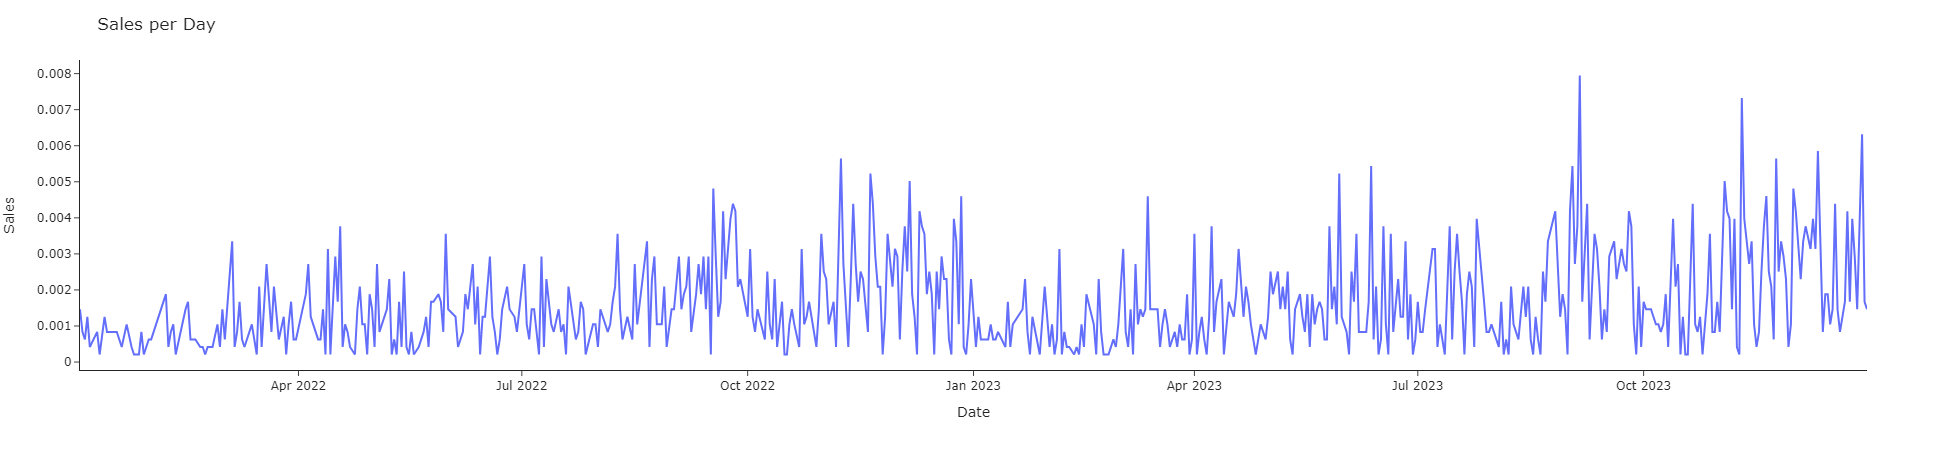

In [19]:

df_count = df['Date'].value_counts('Sales').reset_index()
df_count.columns = ['Date', 'Sales']
df_count = df_count.sort_values('Date')
fig = px.line(df_count,x='Date',y='Sales')
fig.update_layout(template="simple_white",title = 'Sales per Day')


We can definitely notice some trends going on in the end and mid of the year, let's take a look in a monthly level, to confirm these patterns

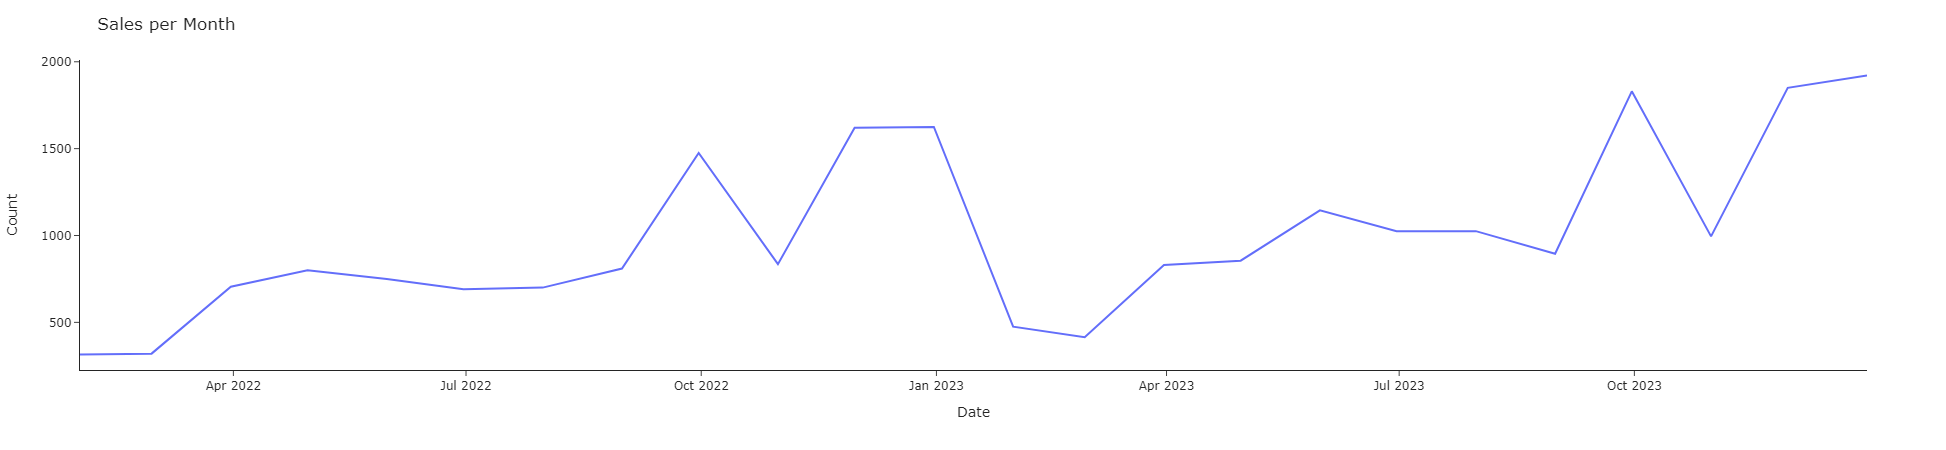

In [17]:
df_monthly = df.set_index('Date')
df_monthly = df_monthly.resample('ME').size().reset_index(name='Count')
fig = px.line(df_monthly,x='Date',y='Count')
fig.update_layout(template="simple_white",title = 'Sales per Month')


Our suspicion was confirmed!
<br>
We have an upwards trend from the middle of the year until December, after that it starts to fall.
<br>
Just with this, it's easy to assume that most people tend to buy cars towards the end of the year *(maybe is when the bonusses cash in!)*.


Next up, we'll analyze how much people are *paying* for these cars.

#### 4. Analyse the average price paid for a vehicle

To study the price of these cars, we can plot a histogram, that will allow us to judge the price distribution and spot how much the consumer is willing to pay for a car, in average. 

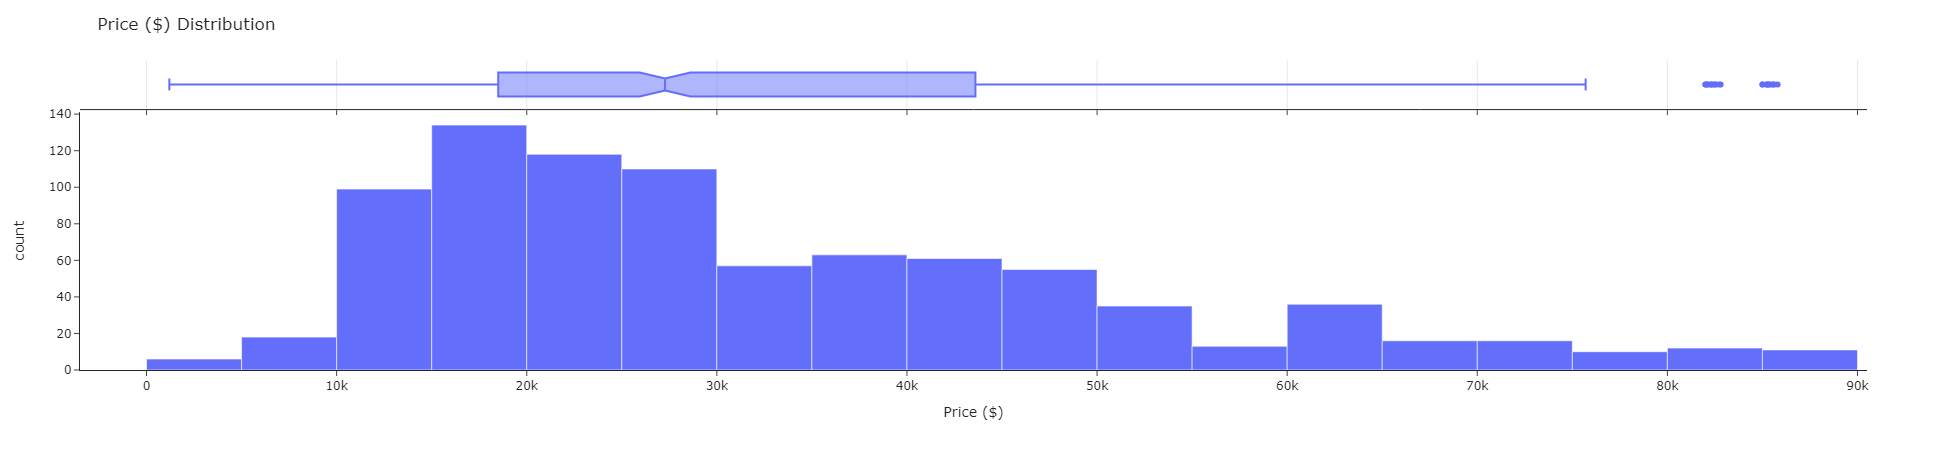

In [16]:
df_price = df.groupby(by='Price ($)').size().reset_index('Price ($)')
fig = px.histogram(df_price,'Price ($)',marginal= 'box')
fig.update_layout(template="simple_white",title = 'Price ($) Distribution')


We can clearly see that this is **not** a normal distribution, this is skewed to the left, in other words, the distribution is centered the around the lower values.
<br>
From this, we can conclude that people tend to pay between **15k - 30k USD**, were the **median is around 27k USD**.
<br> 
We do have a few outliers, paying up to 85k USD!


Ok, now that the pricing analysis is done, we can start slice and dice the data!

#### 5.Understand what types of cars are being sold over time

The first step in understanding what car types (also known as *Body Style*) sells most, is creating a dataframe grouped by the body styles.

In [20]:
df_body = df.groupby(['Date', 'Body Style']).size().reset_index(name='Sales')
df_body.set_index('Date', inplace=True)
df_body.index = pd.to_datetime(df_body.index)

Now we can plot a simple histogram to understand the distribution of body types across the year.

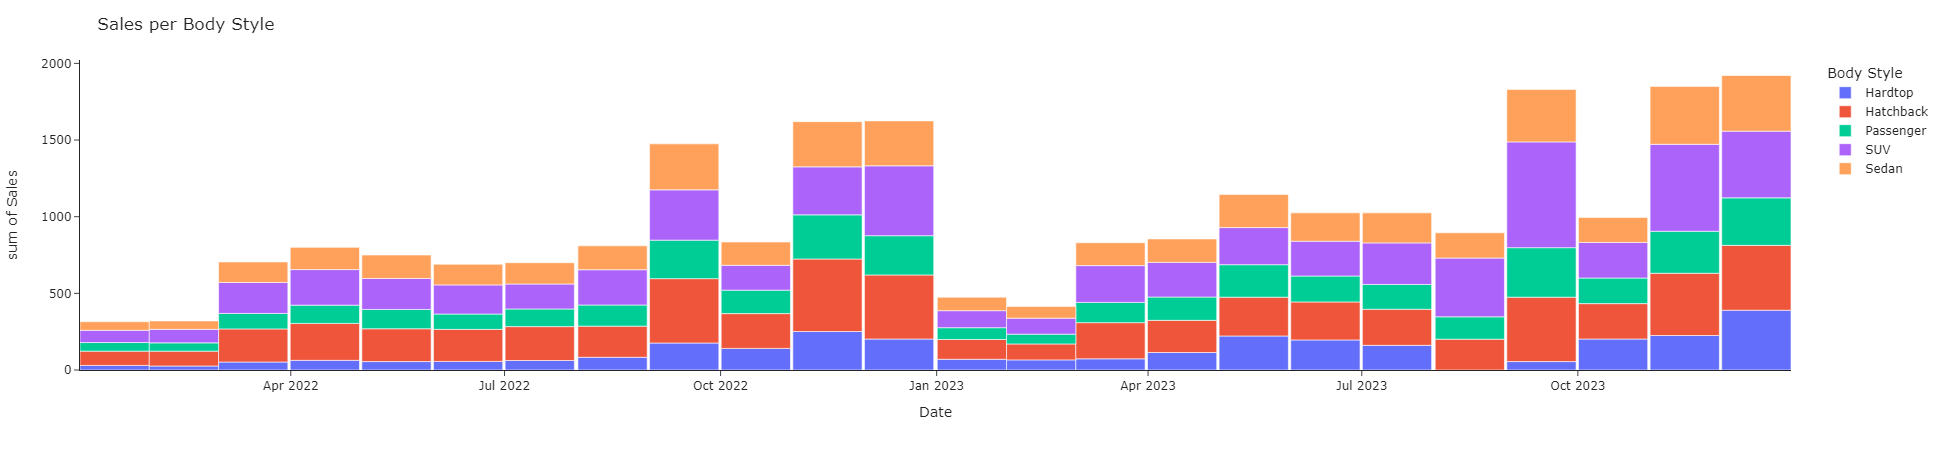

In [21]:
fig = px.histogram(df_body, x=df_body.index,y='Sales',color = 'Body Style').update_yaxes(categoryorder='total ascending')
fig.update_layout(template="simple_white",title= 'Sales per Body Style')


This tells us that the hatchback style was one of the most sold types until December 2022, after that we see a low on sales (which is to be expected), but then, the rise of the *SUV* type begins, taking the first place in sales by the end of 2023.
<br><br>
Let's explore these numbers even further, comparing the overall **YoY growth**.

In order to do this, we need to resample the monthly data into yearly, and then, create a graph that highlights the biggest growth per body type across the year.

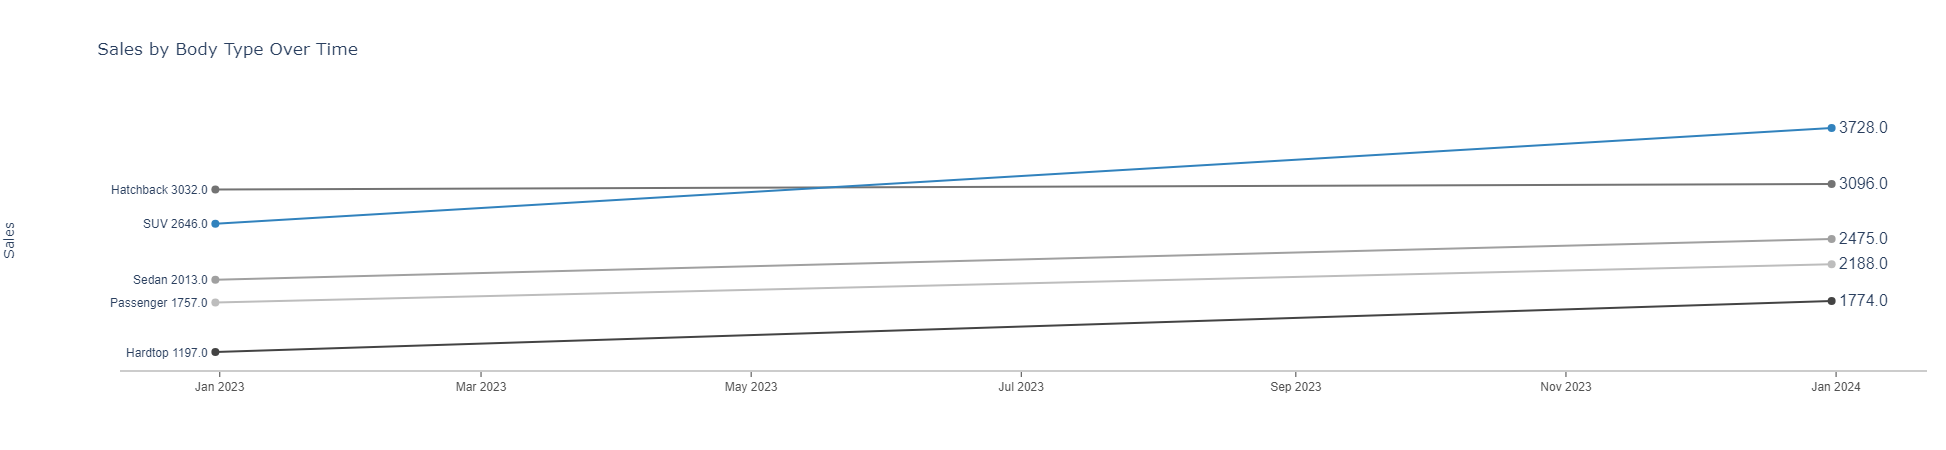

In [23]:
df_monthly = df_body.groupby([pd.Grouper(freq='YE'), 'Body Style']).sum().reset_index()

df_pivot = df_monthly.pivot_table(index='Date', columns='Body Style', values='Sales', fill_value=0)

labels = df_pivot.columns.tolist()
colors = ['rgb(67,67,67)', 'rgb(115,115,115)', 'rgb(189,189,189)','rgb(49,130,189)','rgb(160,160,160)']

fig = go.Figure()

for i, label in enumerate(labels):
    x_data = df_pivot.index
    y_data = df_pivot[label]
    
    fig.add_trace(go.Scatter(x=x_data, y=y_data, mode='lines',
        name=label,
        line=dict(color=colors[i % len(colors)]),
        connectgaps=True,
    ))

    # Add endpoints as markers
    fig.add_trace(go.Scatter(
        x=[x_data[0], x_data[-1]],
        y=[y_data.iloc[0], y_data.iloc[-1]],
        mode='markers',
        marker=dict(color=colors[i % len(colors)], size=8)
    ))

fig.update_layout(
    title='Sales by Body Type Over Time',
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False,
        showticklabels=False,
        title='Sales'
    ),
    autosize=True,
    margin=dict(
        autoexpand=False,
        l=120,
        r=20,
        t=110,
    ),
    showlegend=True,
    plot_bgcolor='white'
)


annotations = []


for label, color in zip(labels, colors):
    y_trace = df_pivot[label].tolist()
    annotations.append(dict(xref='paper', x=0.05, y=y_trace[0],
                            xanchor='right', yanchor='middle',
                            text=label + ' {}'.format(y_trace[0]),
                            font=dict(family='Arial',
                                      size=12),
                            showarrow=False))
    annotations.append(dict(xref='paper', x=0.95, y=y_trace[-1],
                            xanchor='left', yanchor='middle',
                            text='{}'.format(y_trace[-1]),
                            font=dict(family='Arial',
                                      size=16),
                            showarrow=False))

fig.update_layout(annotations=annotations)






This is the perfect representation to see the growth of SUV sales.
<br>
SUV alone had a **~40% growth**
<br>
Were all the other categories barley had half of this.
<br><br>
This tells us that the market will be more focused on selling SUV's due to the higher demand, it's a safe bet, more offers may come by, it might be easier to encounter good used SUV's, companies will be manufacturing more aftermarket parts for repair, etc.
<br>
And sense we already studied the price distribution, the SUV's price will not fluctuate much from that


Just out of curiosity, we're going to see how much of an impact gender has on sales, basically, I want to see which Body Style men and woman prefers. 

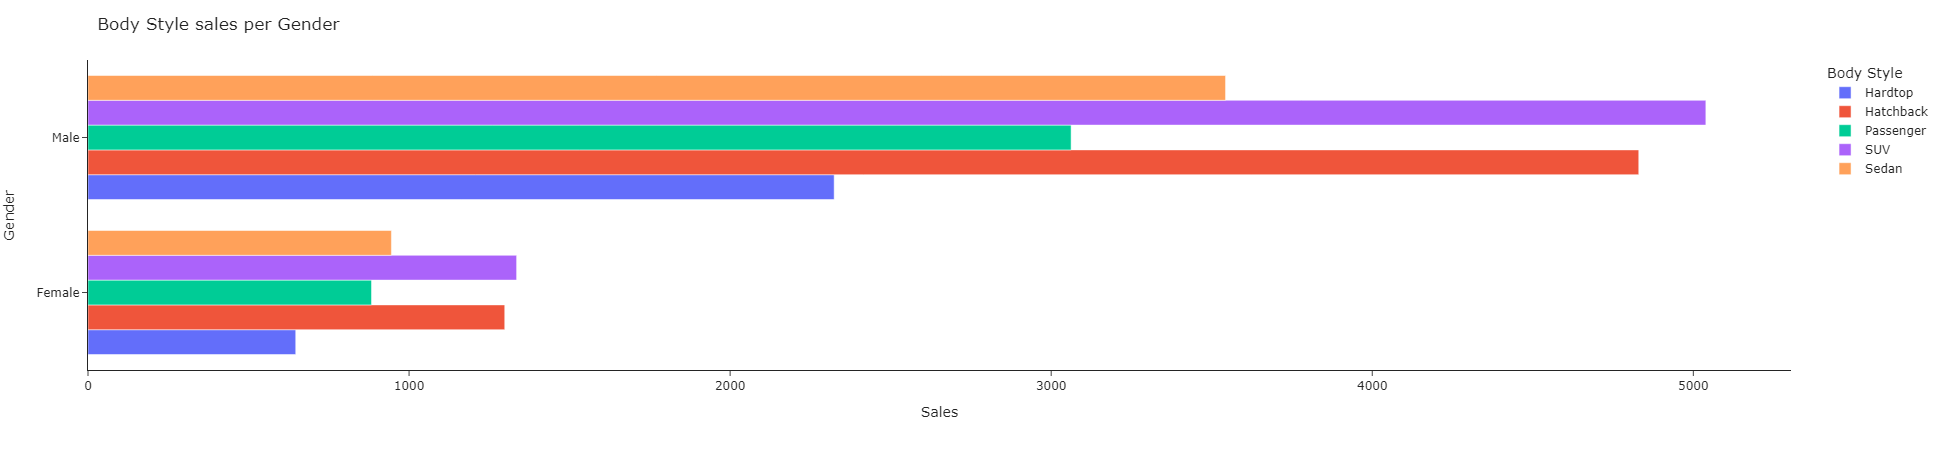

In [24]:
gender_df = df.groupby(['Gender','Body Style']).size().reset_index(name='Sales')
gender_df
fig = px.bar(gender_df,x='Sales',y='Gender',color='Body Style',barmode='group',orientation='h')
fig.update_layout(barmode='group', template="simple_white",title = 'Body Style sales per Gender')


From this alone, the only thing that we can conclude is that **man tends to buy more cars** than woman, but the body style distribution is mostly the same.

#### 6. Study the seasonal components of car types 

With the overall study done on the body style, we can now focus on **decomposing** this time series into:
- seasonal component
- trend
- residuals

##### 6.1 Seasonal Component

In order to decompose a time series and extract the seasonal component, we're going to use seasonal_decompose, followed by the .seasonal method

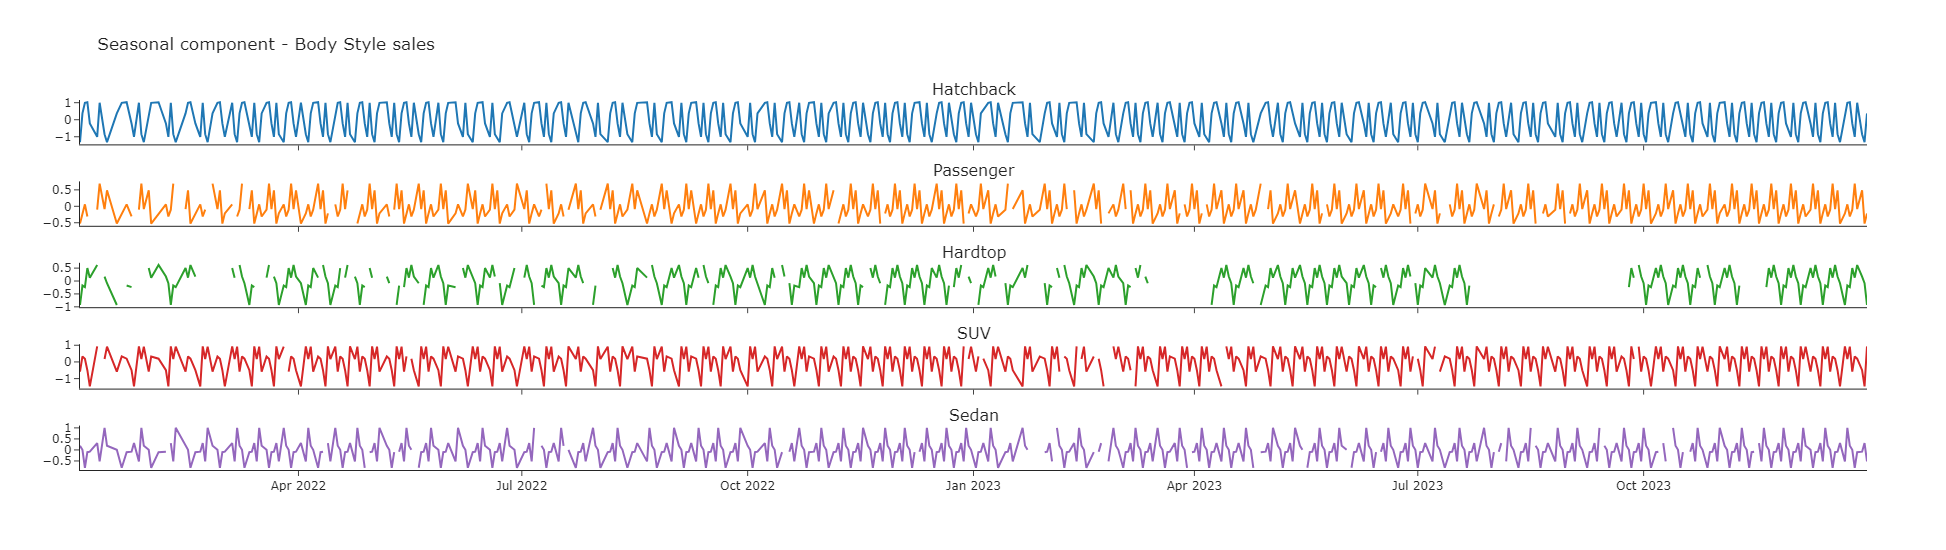

In [25]:
data_dict = {}

body_style_list = list(set(df['Body Style']))
fig = make_subplots(rows= len(body_style_list), cols =1,shared_xaxes=True,subplot_titles=(body_style_list))

for j,r in zip(body_style_list, range(1,len(body_style_list)+1)):
    df_count_body = df[df['Body Style']== j]
    df_count_body = df_count_body['Date'].value_counts().reset_index()
    df_count_body = df_count_body.sort_values('Date')
    pd.to_datetime(df_count_body['Date'])
    df_count_body.set_index('Date', inplace= True)
    decomp_body = sm.tsa.seasonal_decompose(df_count_body['count'],period = 8, model = 'additive')
    data_dict[j] = decomp_body.seasonal
    dict_df = pd.DataFrame(data_dict)
    fig.add_trace(
        go.Scatter(x=dict_df.index,y=dict_df[j],name = j),row=r,col=1
    )
fig.update_layout(showlegend = False,template="simple_white",title = 'Seasonal component - Body Style sales',height=550)
     
    


We can definitely see some seasonal effects in the body types, starting somewhat week in the beginning of the year and getting more evident by the end.

##### 6.2 Trend Component

Very similar to the seasonal analysis, but now, we're going to use the .trend method.

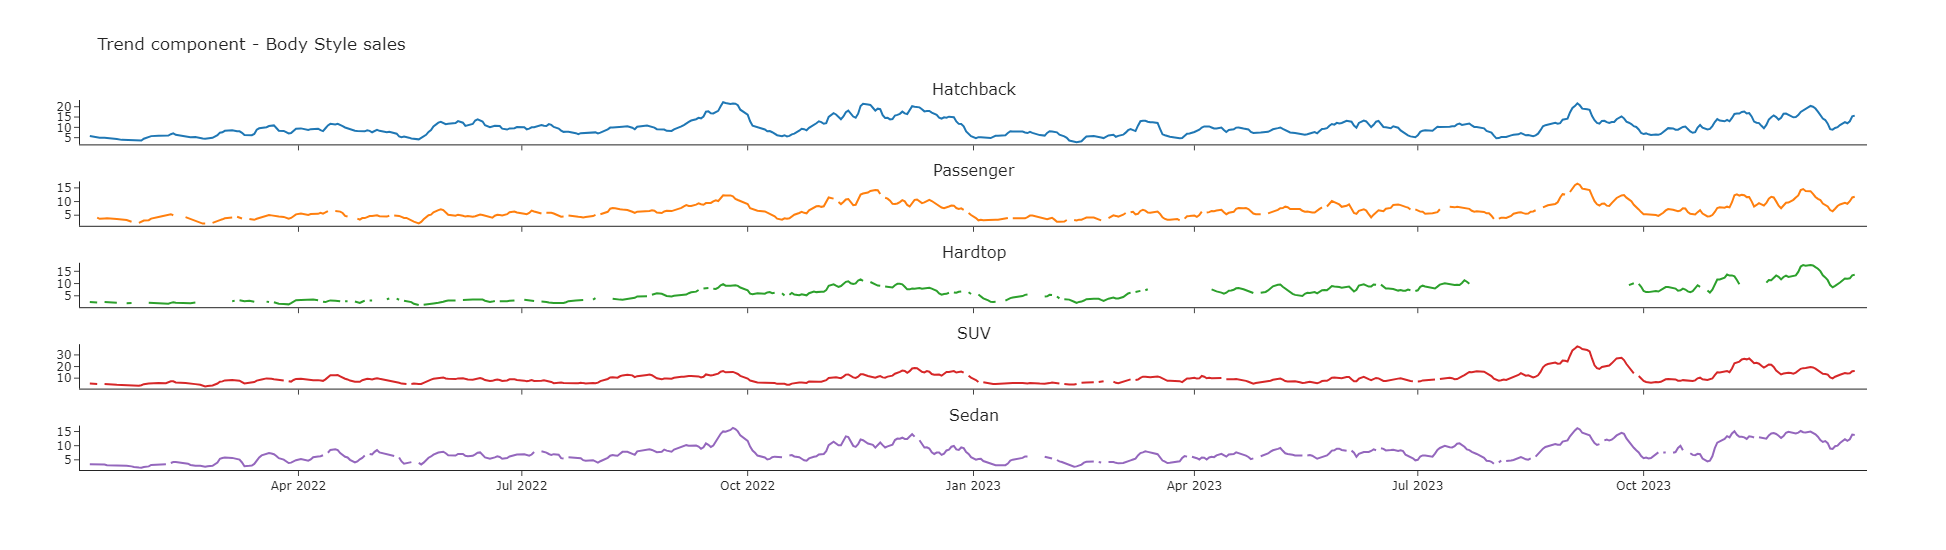

In [26]:
data_dict = {}
fig = make_subplots(rows= len(body_style_list), cols =1,shared_xaxes=True,subplot_titles=(body_style_list))

for j,r in zip(body_style_list, range(1,len(body_style_list)+1)):
    df_count_body = df[df['Body Style']== j]
    df_count_body = df_count_body['Date'].value_counts().reset_index()
    df_count_body = df_count_body.sort_values('Date')
    pd.to_datetime(df_count_body['Date'])
    df_count_body.set_index('Date', inplace= True)
    decomp_body = sm.tsa.seasonal_decompose(df_count_body['count'],period = 8, model = 'additive')
    data_dict[j] = decomp_body.trend
    dict_df = pd.DataFrame(data_dict)
    fig.add_trace(
        go.Scatter(x=dict_df.index,y=dict_df[j]),row=r,col=1
    )
fig.update_layout(showlegend = False,template="simple_white",title = 'Trend component - Body Style sales',height=550)
  

Here we can see even more clearly that we do have a **trend when approaching the end of the year**, in almost all Body Styles
<br><br>
Interesting to see that the Hatchback category it's the only one that has **sales** practically **everyday**!


##### 6.3 Residuals  


The residuals analysis is aimed to see if we have some noise in our data, noise will always be present and this will be very useful if we decide to do a time series forecast on this data. 
<br>
For this, we going to use the .resid method.

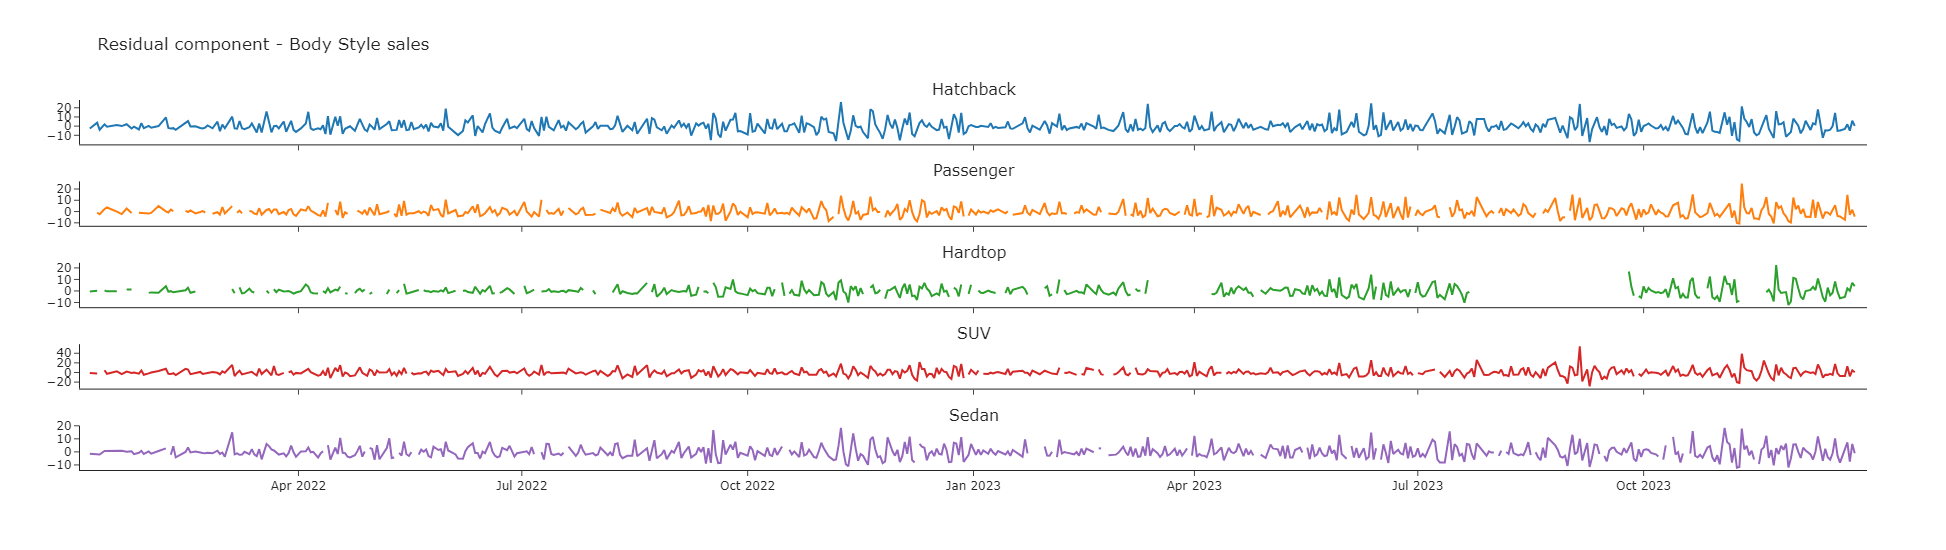

In [27]:
data_dict = {}
fig = make_subplots(rows= len(body_style_list), cols =1,shared_xaxes=True,subplot_titles=(body_style_list))

for j,r in zip(body_style_list, range(1,len(body_style_list)+1)):
    df_count_body = df[df['Body Style']== j]
    df_count_body = df_count_body['Date'].value_counts().reset_index()
    df_count_body = df_count_body.sort_values('Date')
    pd.to_datetime(df_count_body['Date'])
    df_count_body.set_index('Date', inplace= True)
    decomp_body = sm.tsa.seasonal_decompose(df_count_body['count'],period = 8, model = 'additive')
    data_dict[j] = decomp_body.resid
    dict_df = pd.DataFrame(data_dict)
    fig.add_trace(
        go.Scatter(x=dict_df.index,y=dict_df[j]),row=r,col=1
    )
fig.update_layout(showlegend = False,template="simple_white",title = 'Residual component - Body Style sales',height=550)
     
    


Indeed we have noise in every category, but this is common, the only thing to notice is that, the noise is proportional to the trend, in this case.
<br><br>
The Hatchback, that has sales every day, contain much more noise than the other categories, and **SUV** only contains **significant noise** on a few month at the **end of the year**.



#### 7. Identify the car companies that are selling the most

We're almost done helping you decide which car you should be buying.
<br><br>
After studying all the car types, now we need to figure it out what car company is selling the most.
<br>
We're going to do that by grouping our data by the company.
<br>
After that, we going to create a list for the top selling company se we can highlight that on the graph!

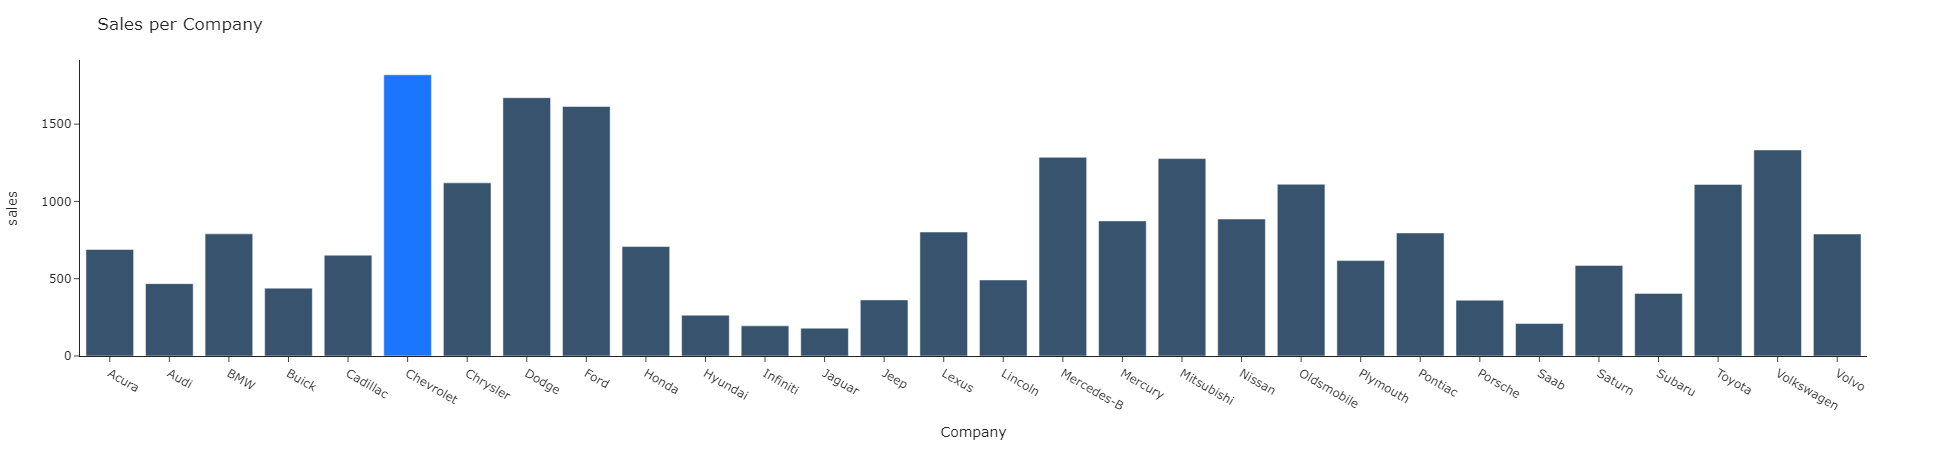

In [28]:
company_df = df.groupby(['Company']).size().reset_index(name='sales')
#suv_df = company_df[company_df['Body Style'] == 'SUV']
top_company = company_df.sort_values(by='sales',ascending=False).head(1)
top_company = list(top_company['Company'])

default_color = 'rgb(55, 83, 109)'
highlight_color = 'rgb(26, 118, 255)'
colors = {top_company[0]: highlight_color}

color_discrete_map = {
    c: colors.get(c, default_color) 
    for c in company_df.Company.unique()}

fig = px.bar(company_df,x='Company',y='sales',color='Company',color_discrete_map=color_discrete_map)
fig.update_layout(template="simple_white",title = 'Sales per Company',showlegend = False)



It looks like **Chevrolet** is our company of choice, it's the top selling car company, followed by Dodge and Ford.
<br><br>
Shall we analyze the best-selling Chevrolet models then?


#### 8. From the top selling company, identify the best-selling car model and color

Finally, we're going to decide on the car model to purchase, it's possible to go even a step further and select only the SUV category for this analysis, but I preferred to leave it open!
<br><br>
In order to do that, we need to group our data by Car Model and Color, so we can plot a stacked bar chart to see the data. 

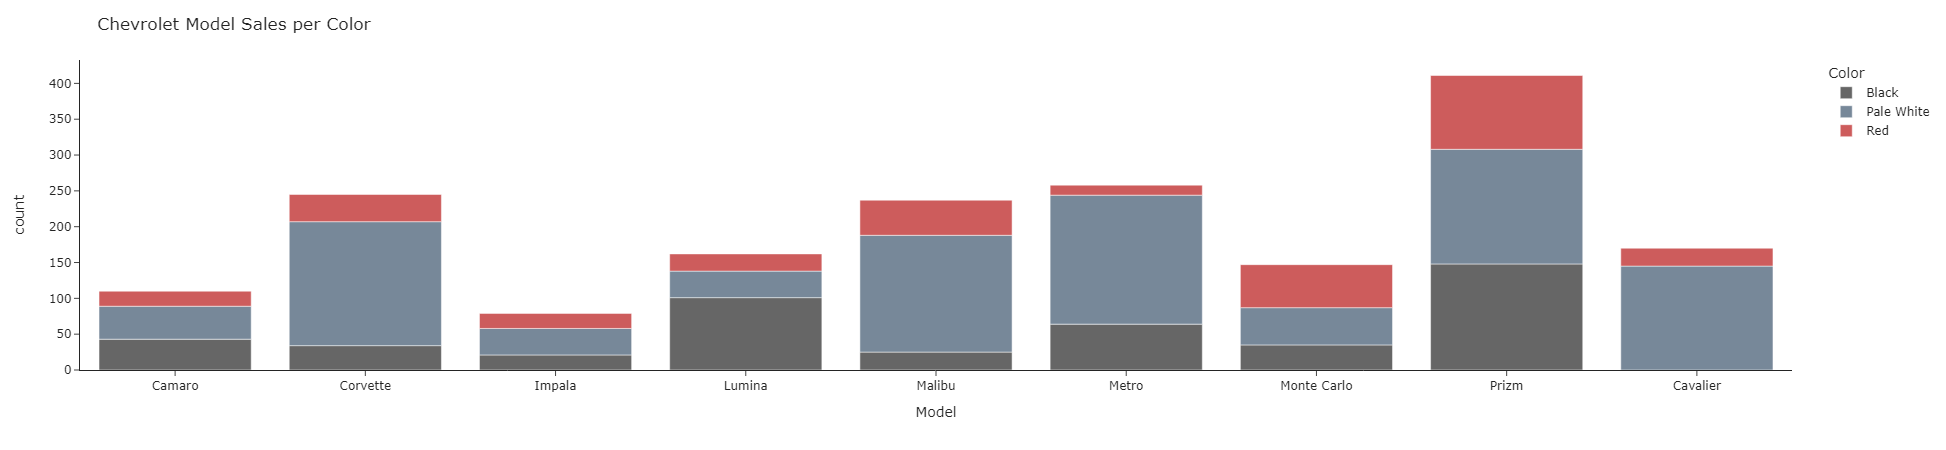

In [30]:
default_color = 'rgb(55, 83, 109)'
colors = {"Red": 'indianred', 'Black':'rgb(102,102,102)','Pale White':'lightslategray'}

color_discrete_map = {
    c: colors.get(c, default_color) 
    for c in df.Color.unique()}

model_suv_df = df[(df['Company'] == top_company[0])]
model_suv_df = model_suv_df.groupby(['Model','Color']).size().reset_index(name='count')
fig = px.bar(model_suv_df,x='Model',y='count',color='Color',color_discrete_map=color_discrete_map)
fig.update_layout(template="simple_white",title = top_company[0]+' Model Sales per Color')



It looks like the model we should be looking at is the **Chevrolet Prizm**, in the Pale White Color, this is the safest bet of all our options here.
<br>
Now, let's see how much you should be paying for this car.

#### 9. Study the average price you should be willing to pay for that particular model

We're almost done with the analysis, the only thing that's left is to do a second distribution analysis on Price, just like we did at the start, but filtering only the top selling company and the top selling model of that company.
<br><br>
The process is fairly simple, we're going to create a *list* to identify the *bestselling model* based on a dataframe that's already filtered by the top selling company, that way *we can use the list result as a filter argument* when we group by the data by the price, similar to what we did in the previous steps.

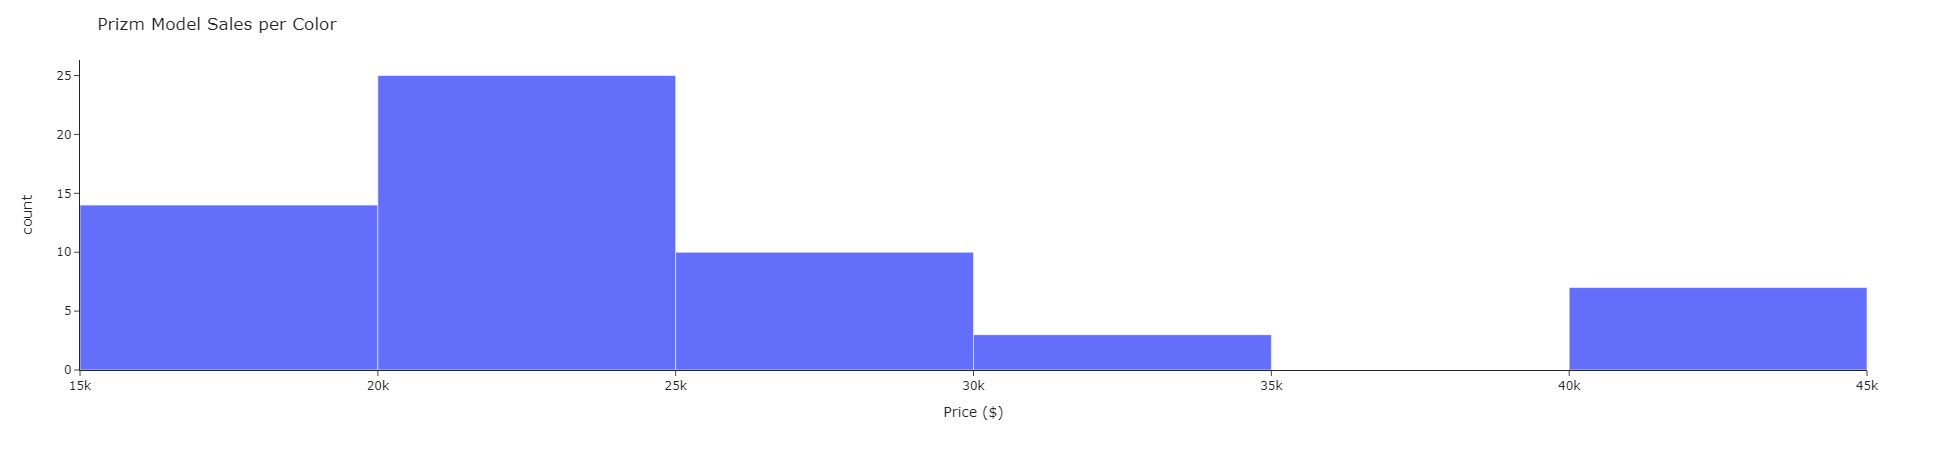

In [31]:
list_top_model = df[df['Company'] == top_company[0]]
list_top_model = list_top_model.groupby('Model').size().reset_index(name = 'Sales')
list_top_model = list_top_model.sort_values(by='Sales',ascending=False).head(1)
list_top_model = list(list_top_model['Model'])

df_top_model = df[df['Model'] == list_top_model[0]]
df_top_model = df_top_model.groupby(by='Price ($)').size().reset_index('Price ($)')
fig = px.histogram(df_top_model,'Price ($)')
fig.update_layout(template="simple_white",title = list_top_model[0]+' Price ($) Distribution')


This distribution tells us that the average price you should be willing to pay for a Chevrolet Prizm is between **20k to 25k USD**.
<br>
And if even possible to encounter cheaper ones, or negotiate the price, but **anything above this price range is simply not worth it**.

#### 10. Conclusion

We started with a simple question, that most of had or will have in life: ***"Which car should I buy?"***
<br>
After the analysis we notice that not only the demand is higher towards the end of the year, but that the prices don't vary too much, so is worth to take a look at some deals around this time period.
<br><br>
Also, **SUVs** are the most sold vehicle type, and it tends to grow even more, and that the bestselling company is **Chevrolet**, that means this companies tend to be reliable and a safe bet for consumers, due to the number of sales, and the bestselling model is the **GM Prizm** (Preferably Pale White), interestingly enough, the model for the company is not and SUV per say.
<br><br>
So, if you're in doubt, one of the safest options for you might be this, based on the number of sales, it represents a car that the average consumer goes to.
<br><br>
And just like that, using some simple data analysis methods in python, we could extract what the raw data has stored for us, shaping it to best fit our needs.
<br>
The best part is that this analysis is fully customizable and can offer way more insight, and that's the beauty of Data Analytics!
<br><br><br>
*Hope you liked the analysis, feel free to check out my LinkedIn and my GitHub.*
